# Coded By: Rahul Raghav
AI22MTECH13007

# Imports

In [ ]:
import os
from google.colab import drive

import random, glob, io

import cv2
import numpy as np
import matplotlib.pyplot as plt

import time

import torch
import torch.nn.init as init
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore") 


# Mount Drive

In [ ]:
#Mount Google Drive to G-colab
def mountDrive():

  drive.mount('/content/drive')
  %cd ./drive/MyDrive/IVP_project/code
  

  print(os.listdir())

mountDrive()

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XU-e2aD1WavwuES22t5g54C6mW56TWPT/IVP_project/code
['images', '__pycache__', '.ipynb_checkpoints', 'pretrained', 'Weights_DnCNN_S_SGD.pickle', 'Exsisting.ipynb', 'Weights_DnCNN_S_Adam.pickle', 'Weights_DnCNN_S_Adam_Gray.pickle', 'Weights_DnCNN_B.pickle', 'dataset.py', 'ID_DnCNN_B.pth', 'net_attention_singlevar.pth', 'net_attention_blind.pth', 'utils.py', '.DS_Store', 'ID_DL_DnCNN_S.pth', 'data', 'DnCNN_self_attention.ipynb', 'DnCNN_GPU_MTR-9.ipynb', 'ID_DnCNN_S.pth', 'ID_DL_DnCNN_S_gray.pth', 'ID_DnCNN_S_gray.pth', 'Deep_DnCNN_GPU.ipynb', 'Deep_Dialated_DnCNN_GPU.ipynb']


# Plot Images & Graphs

In [ ]:
"""
This block is to setup a code that will take care of displaying the images
"""

def imshow(I, title="Image"):
    plt.title(title)
    plt.imshow(I, cmap='gray')

def showImages(*Images,titles=[], figsize=(15,15)):
    I_count = len(Images)

    plt.subplots(1,I_count, figsize=figsize)

    for pos, I in enumerate(Images):
        plt.subplot(1,I_count,pos+1)
        try:
            imshow(I,titles[pos])
        except:
            imshow(I)
    
    plt.show()

In [ ]:
'''
 This function plots the graph
'''
def plot(*plots, legends=None, title='Plot', xlabel='Epochs', ylabel=''):
    plt.title(title)
    for i,hist in enumerate(plots):
        plt.plot(hist, label=legends[i],)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

# Arguments

In [ ]:
args = {
    'paths':{
        'train_data': "./images/train/",
        'test_data': "./images/test/",
    },
    'hyper': {
        'depth': 21, # Depth of Network
        'lr': 1E-4,
        'momentum': 0.9,
        'batch_size': 128,
        'weight_decay': 1E-3,
        'kernel_size': 3,
        'dilation': 4,
        'epochs': 50,
        'grad_clip': 0.1,
        'noise_levels': [25]
    }
}

log = {
    'ID_DL_DnCNN_S':{
        'train_loss': [],
        'train_psnr': []
    },
    'ID_DL_DnCNN_S_gray':{
        'train_loss': [],
        'train_psnr': []
    },
    'ID_DL_DnCNN_B':{
        'train_loss': [],
        'train_psnr': []
    }
}

# Device Setter

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def check_cuda(model):
    for name, param in model.named_parameters():
        if param.is_cuda:
            print(f"{name} is on CUDA")
        else:
            print(f"{name} is not on CUDA")

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

# Residual CNN 

In [ ]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, D, kernelSize = 3, dilation=1, imgChannels=3, nChannels=64, batchSize = 128, randomState = 0):
        super(CNN, self).__init__()

        #Seed for Reproducibility
        torch.manual_seed(randomState)

        #Calculate Appropriate Padding according to Kernel Size
        pad = dilation*(kernelSize-1)//2

        self.batchSize = batchSize

        # Conv+ReLU: 64 filters (3x3xc), c: no. of image channels, padding: to maintain spatial dimensions
        self.conv1 = nn.Conv2d(in_channels=imgChannels, out_channels=nChannels, kernel_size=kernelSize, padding=pad,dilation=dilation)
        self.relu = nn.ReLU(inplace=True)

        conv_Layers = []
        for i in range(D-1):
          if(i < 5 or i > 15):
            conv_Layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=nChannels, out_channels=nChannels, kernel_size=kernelSize, padding=pad,dilation=dilation),
                    nn.BatchNorm2d(nChannels,eps=0.0001, momentum = 0.9),
                    nn.ReLU()
                )
            )
          elif(i == 5):
            conv_Layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=nChannels, out_channels=2*nChannels, kernel_size=kernelSize, padding=pad,dilation=dilation),
                    nn.BatchNorm2d(2*nChannels,eps=0.0001, momentum = 0.9),
                    nn.ReLU()
                )
            )
          elif(i < 15):
            conv_Layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=2*nChannels, out_channels=2*nChannels, kernel_size=kernelSize, padding=pad,dilation=dilation),
                    nn.BatchNorm2d(2*nChannels,eps=0.0001, momentum = 0.9),
                    nn.ReLU()
                )
            )
          elif(i == 15):
            conv_Layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=2*nChannels, out_channels=nChannels, kernel_size=kernelSize, padding=pad,dilation=dilation),
                    nn.BatchNorm2d(nChannels,eps=0.0001, momentum = 0.9),
                    nn.ReLU()
                )
            )
        self.convLayers = nn.ModuleList(conv_Layers)
        # Last Layer: c filters(3x3x64) to recostruct the image
        self.output = nn.Conv2d(in_channels=nChannels, out_channels=imgChannels, kernel_size=kernelSize, padding=pad,dilation=dilation)

        self._initialize_weights()
        
    def forward(self, x):
        #Conv+Relu
        y = x.clone() #Noisy Images
        x = self.conv1(x)
        x = self.relu(x)
        # 2 ~ (D-1) layers
        for i,conv in enumerate(self.convLayers):
            x = conv(x)

        out = self.output(x) #  Learned Noise

        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)



In [ ]:
CNN(21)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (convLayers): ModuleList(
    (0-4): 5 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=0.0001, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=0.0001, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (6-14): 9 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=0.0001, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (15): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=0.0001, momentum=0.9, affine=True, track_running_stats=True)
      (2):

# Dataset Creation

In [ ]:
"""
    Converts RGB Image to Grayscale
"""
def grayscale(rgb):
    if(len(rgb.shape) == 3):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    else:
        return rgb

In [ ]:
def create_train_dataset(data_path, model_type, noise_level=[25], stride=30, isGrayscale=False ):
    if model_type == "DnCNN-S":
      patch_shape = (40, 40, 3)
    elif model_type in ["DnCNN-B"]:
      patch_shape = (50, 50, 3)
    else:
        print("wrong type")
        exit()

    if(isGrayscale):
        patch_shape = patch_shape[:2]
    
    dataset= DnCNN_train_Dataset(data_path, model_type, patch_shape=patch_shape, noise_level=noise_level, isGrayscale=isGrayscale)    

    data = dataset.getPatches(stride)
      
    return data

def create_test_dataset(data_path, model_type, noise_level=[25], isGrayscale=False):
    # define dataset
    dataset= DnCNN_train_Dataset(data_path, model_type, noise_level=noise_level, isGrayscale=isGrayscale)    

    data = dataset.getTestImages()
    
    return data


class DnCNN_train_Dataset():
    def __init__(self, dataset_path, model_type, noise_level=[25],\
                 image_shape=(180, 180), patch_shape=(50, 50), isGrayscale=False):
      
        if(isGrayscale):
          self.im_list = [grayscale(plt.imread(file)) for file in glob.glob(f'{dataset_path}*.jpg')]
        else:
          self.im_list = [plt.imread(file) for file in glob.glob(f'{dataset_path}*.jpg')]
        self.noise_level = noise_level
        self.patch_shape = patch_shape
        self.image_shape = image_shape
        self.model_type = model_type
        self.sigma_range = (0, 55)
        self.isGrayscale = isGrayscale

    def getPatches(self, stride):
        patches = []
        for img in self.im_list:
            img_h, img_w = (180,180)
            img = cv2.resize(img, (img_h, img_w))
            
            sigma = random.choice(self.noise_level)

            """
            take overlapping samples
            """
            for i in range(0,img_h, stride):
              for j in range(0,img_w, stride):
                  if(self.isGrayscale):
                    patch = img[i:i+self.patch_shape[0], j:j+self.patch_shape[1]]
                  else:
                    patch = img[i:i+self.patch_shape[0], j:j+self.patch_shape[1],:]
                  # print(self.patch_shape)

                  if(patch.shape[:2] == (self.patch_shape[:2])):

                    #add noise
                    if self.model_type == "DnCNN-S":
                        #add specific level of noise
                        noisy = self.add_noise(patch, sigma) 
                    elif self.model_type == "DnCNN-B":
                        #add random level of noise
                        sigma = random.uniform(*self.sigma_range)
                        noisy = self.add_noise(patch, sigma)
                    else:
                        print("wrong type")
                        exit()
                    noise = np.float32(noisy) - np.float32(patch)

                    #normalize
                    noisy = noisy / 255.0
                    noise = noise / 255.0

                    if(self.isGrayscale):
                      noisy = torch.tensor(noisy, dtype=torch.float).unsqueeze(0)
                      noise = torch.tensor(noise).unsqueeze(0)
                    else:
                      noisy = torch.tensor(noisy.transpose(2,0,1), dtype=torch.float)
                      noise = torch.tensor(noise.transpose(2,0,1))

                    # print('-< ',noisy.device)

                    patches.append((noisy, noise))

        print(f'\nDataset Shape: {np.array(patches).shape}\n')
        return patches
        
    def getTestImages(self):
        patches = []
        for img in self.im_list:
            img_h, img_w = (180,180)
            img = cv2.resize(img, (img_h, img_w))
            
            sigma = random.choice(self.noise_level)

            if self.model_type == "DnCNN-S":
                #add specific level of noise
                noisy = self.add_noise(img, sigma) 
            elif self.model_type == "DnCNN-B":
                #add random level of noise
                sigma = random.uniform(*self.sigma_range)
                noisy = self.add_noise(img, sigma)
            else:
                print("wrong type")
                exit()
            noise = np.float32(noisy) - np.float32(img)

            #normalize
            noisy = noisy / 255.0
            noise = noise / 255.0

            if(self.isGrayscale):
              noisy = torch.tensor(noisy, dtype=torch.float).unsqueeze(0)
              noise = torch.tensor(noise).unsqueeze(0)
            else:
              noisy = torch.tensor(noisy.transpose(2,0,1), dtype=torch.float)
              noise = torch.tensor(noise.transpose(2,0,1))

            patches.append((noisy, noise))


        print(f'\nDataset Shape: {np.array(patches).shape}\n')
        return patches

    def add_noise(self, im, sigma):
        gauss = np.random.normal(0, sigma, im.shape)
        noisy = im+gauss
        noisy = np.clip(noisy, 0, 255).astype('uint8')
        return noisy


# Train DnCNN-S 
function definition

In [ ]:
def plot(loss_hist, title, xlabel, ylabel):
  plt.plot(np.arange(0,len(loss_hist),1), loss_hist)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [ ]:
def trainModel(model_name, batches, D, ks, dil, epochs, lr, m, wd, grad_clip, opt_algo, metric, isGrayscale=False):
  torch.cuda.empty_cache()
  #Instantiate the model
  if(isGrayscale):
    RES_CNN = CNN(D,kernelSize=ks,dilation = dil,  imgChannels=1)
  else:
    RES_CNN = CNN(D,kernelSize=ks,dilation = dil)

  #Set it to GPU
  RES_CNN_gpu = to_device(RES_CNN, device)

  #To Check Model device type of parameters
  # check_cuda(RES_CNN_gpu)

  # Define the loss function and optimizer
  if(opt_algo == 'SGD'):
    optimizer = optim.SGD(RES_CNN_gpu.parameters(), lr=lr, momentum=m, weight_decay=wd)
  else:
    optimizer = optim.Adam(RES_CNN_gpu.parameters(), lr=lr, weight_decay=wd)
  
  # scheduler = MultiStepLR(optimizer, milestones=[20, 40, 90], gamma=0.2)  # learning rates

  # Train the CNN
  for epoch in range(epochs):
      # RES_CNN_gpu.train()
      # scheduler.step(epoch)  # step to the learning rate in this epcoh
      running_loss = 0.0
      psnr = 0
      for batch in batches:
          inputs, labels = batch
          optimizer.zero_grad()
          outputs = RES_CNN_gpu(inputs) #denoised Image

          psnr  += metric(inputs-labels, inputs-outputs)

          #Using Frobenious Norm Loss
          loss = torch.norm(labels-outputs)/(2*128)

          loss.backward()

          nn.utils.clip_grad_value_(RES_CNN_gpu.parameters(), grad_clip)
          optimizer.step()
          running_loss += loss.item()

      # scheduler.step(epoch)  # step to the learning rate in this epcoh
      running_loss = running_loss /len(batches)
      psnr = psnr/len(batches)
      print(f'Epoch: [{epoch + 1}/{epochs}], Loss: {running_loss:.5f}, PSNR: {psnr:.3f}')
      log[model_name]['train_loss'].append(running_loss)
      log[model_name]['train_psnr'].append(psnr)
      running_loss = 0.0

  print('Training Complete... I have learned Enough!!\n')

  return RES_CNN_gpu

# Test DnCNN-S
function definition

In [ ]:
def test(model_name,batches, D, ks, dilation, isGrayscale=False):

  if(isGrayscale):
    model = CNN(D,kernelSize=ks, dilation = dilation,imgChannels=1)
  else:
    model = CNN(D,kernelSize=ks,dilation = dilation)

  model = to_device(model, device)

  model.load_state_dict(torch.load(f'{model_name}.pth'))

  # switch to evaluation mode
  model.eval()

  with torch.no_grad():
      for batch in batches:
          inputs, labels = batch
          outputs = model(inputs)
  return inputs, labels, outputs

# Data Batches

In [ ]:
def getTrainDataBatches(path, model_type, bacthSize, noise_level, isGrayscale=False, stride=30):
  dataset = create_train_dataset(path, model_type, noise_level = noise_level, stride=stride, isGrayscale=isGrayscale)
  batches = DataLoader(dataset, batch_size=bacthSize, shuffle=True, num_workers=2, pin_memory=True)
  batches_gpu = DeviceDataLoader(batches, device)
  return batches_gpu

def getTestDataBatches(path, model_type, noise_level, isGrayscale=False):
  dataset = create_test_dataset(path, model_type, noise_level, isGrayscale = isGrayscale)
  batches = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=2, pin_memory=True)
  batches_gpu = DeviceDataLoader(batches, device)
  return batches_gpu

# Test Utility Functions

In [ ]:
def PSNR(original, compressed):
    original = torch.clone(original.cpu()).detach().numpy()
    compressed = torch.clone(compressed.cpu()).detach().numpy()
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = original.max()
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
def getTotalLoss(lables, outputs):
  mse = nn.MSELoss()
  loss = torch.sum((mse(outputs, lables)))
  return loss.item()


In [ ]:
def getOutput(inputs, labels, outputs):
  inputs = inputs.cpu()
  labels = labels.cpu()
  outputs = outputs.cpu()
  cln_img = inputs - labels #True Clean Image
  prd_img = inputs - outputs #Predicted Clean Image
  psnr = []

  for cl_img, pr_img in zip(cln_img,prd_img):
    psnr.append(PSNR(cl_img, pr_img))

  psnr = np.array(psnr)
  idx = np.argsort(-psnr)

  psnr = psnr[idx]
  inp_subset = (inputs[idx])[:5].permute((0,2,3,1))  #Noisy
  tru_n_subset = (labels[idx])[:5].permute((0,2,3,1)) #Noise
  cln_img_subset = (cln_img[idx])[:5].permute((0,2,3,1)) #true image
  prd_img_subset = (prd_img[idx])[:5].permute((0,2,3,1)) #pred image
  op_subset = (outputs[idx])[:5].permute((0,2,3,1)) #predicted noise

  for i in range(5):
    titles = ['Input Image','True Noise', 'Learned Noise', 'Clean Image', f'Denoised Image\nPSNR: {psnr[i]:0.3f}']
    showImages(inp_subset[i],tru_n_subset[i], op_subset[i], cln_img_subset[i], prd_img_subset[i], titles=titles, figsize=(20,20))

# Train DnCNN-S Model with Adam Optimizer

In [ ]:
model_name = 'ID_DL_DnCNN_S'

hp = args['hyper']

# Load the data and create data loaders
train_batches_gpu = getTrainDataBatches(args['paths']['train_data'], 'DnCNN-S', hp['batch_size'], hp['noise_levels'])

start_time = time.time()
ID_DL_DnCNN_S = trainModel(model_name,train_batches_gpu, hp['depth'], hp['kernel_size'], hp['dilation'], hp['epochs'], hp['lr'], hp['momentum'], hp['weight_decay'], hp['grad_clip'], 'Adam', PSNR)

end_time = time.time()
run_time = round(end_time - start_time)
min = run_time//60
print(f'\nTraining Time in (min:sec): {min}:{(run_time-min*60)%60}\n')

#Save Model
torch.save(ID_DL_DnCNN_S.state_dict(),f'./{model_name}.pth')

del ID_DL_DnCNN_S, train_batches_gpu


Dataset Shape: (10000, 2)

Epoch: [1/50], Loss: 0.47394, PSNR: 17.606
Epoch: [2/50], Loss: 0.29134, PSNR: 20.363
Epoch: [3/50], Loss: 0.28971, PSNR: 20.409
Epoch: [4/50], Loss: 0.28828, PSNR: 20.452
Epoch: [5/50], Loss: 0.28780, PSNR: 20.465
Epoch: [6/50], Loss: 0.28741, PSNR: 20.478
Epoch: [7/50], Loss: 0.28664, PSNR: 20.503
Epoch: [8/50], Loss: 0.28400, PSNR: 20.581
Epoch: [9/50], Loss: 0.27831, PSNR: 20.757
Epoch: [10/50], Loss: 0.26836, PSNR: 21.077
Epoch: [11/50], Loss: 0.25623, PSNR: 21.478
Epoch: [12/50], Loss: 0.24347, PSNR: 21.916
Epoch: [13/50], Loss: 0.23183, PSNR: 22.346
Epoch: [14/50], Loss: 0.22162, PSNR: 22.726
Epoch: [15/50], Loss: 0.21391, PSNR: 23.039
Epoch: [16/50], Loss: 0.20654, PSNR: 23.346
Epoch: [17/50], Loss: 0.20040, PSNR: 23.605
Epoch: [18/50], Loss: 0.19762, PSNR: 23.725
Epoch: [19/50], Loss: 0.19146, PSNR: 23.999
Epoch: [20/50], Loss: 0.18802, PSNR: 24.162
Epoch: [21/50], Loss: 0.18445, PSNR: 24.334
Epoch: [22/50], Loss: 0.18137, PSNR: 24.475
Epoch: [23/50

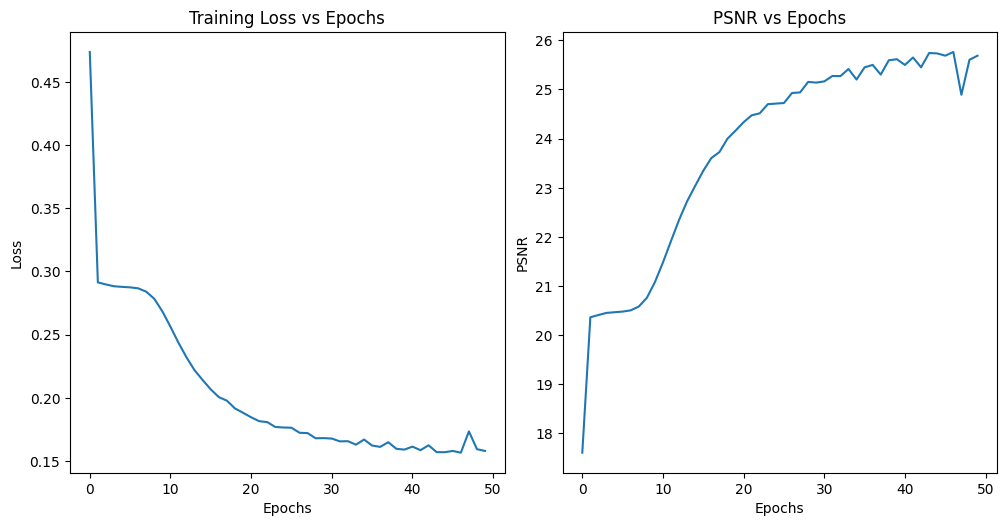

In [ ]:
model_name = 'ID_DL_DnCNN_S'

plt.subplots(1,2, figsize=(10,5))
plt.tight_layout(h_pad=3)
plt.subplot(121)
plot(log[model_name]['train_loss'], 'Training Loss vs Epochs', 'Epochs', 'Loss')
plt.subplot(122)
plot(log[model_name]['train_psnr'], 'PSNR vs Epochs', 'Epochs', 'PSNR')


# Test DnCNN-S Model with Adam Optimizer

In [ ]:
model_name = 'ID_DL_DnCNN_S'
hp = args['hyper']
path = args['paths']

test_batches_gpu = getTestDataBatches(path['test_data'], 'DnCNN-S', hp['noise_levels'])

inputs, labels, outputs = test(model_name,test_batches_gpu,hp['depth'], hp['kernel_size'], hp['dilation'])

print(f"Total Test Loss: {getTotalLoss(labels, outputs)}")

getOutput(inputs, labels, outputs)
del inputs, labels, outputs

Output hidden; open in https://colab.research.google.com to view.

# Train Adam with Grayscale Images

In [ ]:
model_name = 'ID_DL_DnCNN_S_gray'

hp = args['hyper']

# Load the data and create data loaders
train_batches_gpu = getTrainDataBatches(args['paths']['train_data'], 'DnCNN-S', hp['batch_size'], hp['noise_levels'], isGrayscale=True)

start_time = time.time()
ID_DL_DnCNN_S_gray = trainModel(model_name,train_batches_gpu, hp['depth'], hp['kernel_size'], hp['dilation'], hp['epochs'], hp['lr'], hp['momentum'], hp['weight_decay'], hp['grad_clip'], 'Adam', PSNR, isGrayscale=True)

end_time = time.time()
run_time = round(end_time - start_time)
min = run_time//60
print(f'\nTraining Time in (min:sec): {min}:{(run_time-min*60)%60}\n')

#Save Model
torch.save(ID_DL_DnCNN_S_gray.state_dict(),f'./{model_name}.pth')

del ID_DL_DnCNN_S_gray, train_batches_gpu


Dataset Shape: (10000, 2)

1
Epoch: [1/50], Loss: 0.27413, PSNR: 17.510
Epoch: [2/50], Loss: 0.16950, PSNR: 20.291
Epoch: [3/50], Loss: 0.16711, PSNR: 20.418
Epoch: [4/50], Loss: 0.16056, PSNR: 20.765
Epoch: [5/50], Loss: 0.15176, PSNR: 21.249
Epoch: [6/50], Loss: 0.14442, PSNR: 21.686
Epoch: [7/50], Loss: 0.13834, PSNR: 22.063
Epoch: [8/50], Loss: 0.13353, PSNR: 22.357
Epoch: [9/50], Loss: 0.13003, PSNR: 22.596
Epoch: [10/50], Loss: 0.12686, PSNR: 22.805
Epoch: [11/50], Loss: 0.12488, PSNR: 22.950
Epoch: [12/50], Loss: 0.12314, PSNR: 23.049
Epoch: [13/50], Loss: 0.12162, PSNR: 23.177
Epoch: [14/50], Loss: 0.12005, PSNR: 23.284
Epoch: [15/50], Loss: 0.11876, PSNR: 23.392
Epoch: [16/50], Loss: 0.11768, PSNR: 23.459
Epoch: [17/50], Loss: 0.11698, PSNR: 23.512
Epoch: [18/50], Loss: 0.11603, PSNR: 23.584
Epoch: [19/50], Loss: 0.11583, PSNR: 23.598
Epoch: [20/50], Loss: 0.11536, PSNR: 23.635
Epoch: [21/50], Loss: 0.11464, PSNR: 23.693
Epoch: [22/50], Loss: 0.11418, PSNR: 23.724
Epoch: [23/

In [ ]:
model_name = 'ID_DL_DnCNN_S_gray'
hp = args['hyper']
path = args['paths']

test_batches_gpu = getTestDataBatches(path['test_data'], 'DnCNN-S', hp['noise_levels'],isGrayscale=True)

inputs, labels, outputs = test(model_name,test_batches_gpu,hp['depth'], hp['kernel_size'], hp['dilation'],isGrayscale=True)

print(f"Total Test Loss: {getTotalLoss(labels, outputs)}")

getOutput(inputs, labels, outputs)
del inputs, labels, outputs

Output hidden; open in https://colab.research.google.com to view.

# DnCNN Blind

In [ ]:
model_name = 'ID_DL_DnCNN_B'

hp = args['hyper']

# Load the data and create data loaders
train_batches_gpu = getTrainDataBatches(args['paths']['train_data'], 'DnCNN-S', hp['batch_size'], hp['noise_levels'], isGrayscale=True,stride=30)

start_time = time.time()
ID_DL_DnCNN_B = trainModel(model_name,train_batches_gpu, hp['depth'], hp['kernel_size'], hp['dilation'], hp['epochs'], hp['lr'], hp['momentum'], hp['weight_decay'], hp['grad_clip'], 'Adam', PSNR, isGrayscale=True)

end_time = time.time()
run_time = round(end_time - start_time)
min = run_time//60
print(f'\nTraining Time in (min:sec): {min}:{(run_time-min*60)%60}\n')

#Save Model
torch.save(ID_DL_DnCNN_B.state_dict(),f'./{model_name}.pth')

del ID_DL_DnCNN_B, train_batches_gpu


Dataset Shape: (10000, 2)

Epoch: [1/50], Loss: 0.27842, PSNR: 17.392
Epoch: [2/50], Loss: 0.16930, PSNR: 20.301
Epoch: [3/50], Loss: 0.16631, PSNR: 20.459
Epoch: [4/50], Loss: 0.15882, PSNR: 20.860
Epoch: [5/50], Loss: 0.15059, PSNR: 21.316
Epoch: [6/50], Loss: 0.14387, PSNR: 21.719
Epoch: [7/50], Loss: 0.13766, PSNR: 22.105
Epoch: [8/50], Loss: 0.13290, PSNR: 22.398
Epoch: [9/50], Loss: 0.12931, PSNR: 22.643
Epoch: [10/50], Loss: 0.12645, PSNR: 22.833
Epoch: [11/50], Loss: 0.12458, PSNR: 22.971
Epoch: [12/50], Loss: 0.12291, PSNR: 23.066
Epoch: [13/50], Loss: 0.12146, PSNR: 23.188
Epoch: [14/50], Loss: 0.12001, PSNR: 23.286
Epoch: [15/50], Loss: 0.11878, PSNR: 23.390
Epoch: [16/50], Loss: 0.11765, PSNR: 23.462
Epoch: [17/50], Loss: 0.11691, PSNR: 23.518
Epoch: [18/50], Loss: 0.11606, PSNR: 23.582
Epoch: [19/50], Loss: 0.11616, PSNR: 23.572
Epoch: [20/50], Loss: 0.11581, PSNR: 23.602
Epoch: [21/50], Loss: 0.11452, PSNR: 23.704
Epoch: [22/50], Loss: 0.11400, PSNR: 23.737
Epoch: [23/50


Dataset Shape: (100, 2)

Total Test Loss: 111.79026794433594


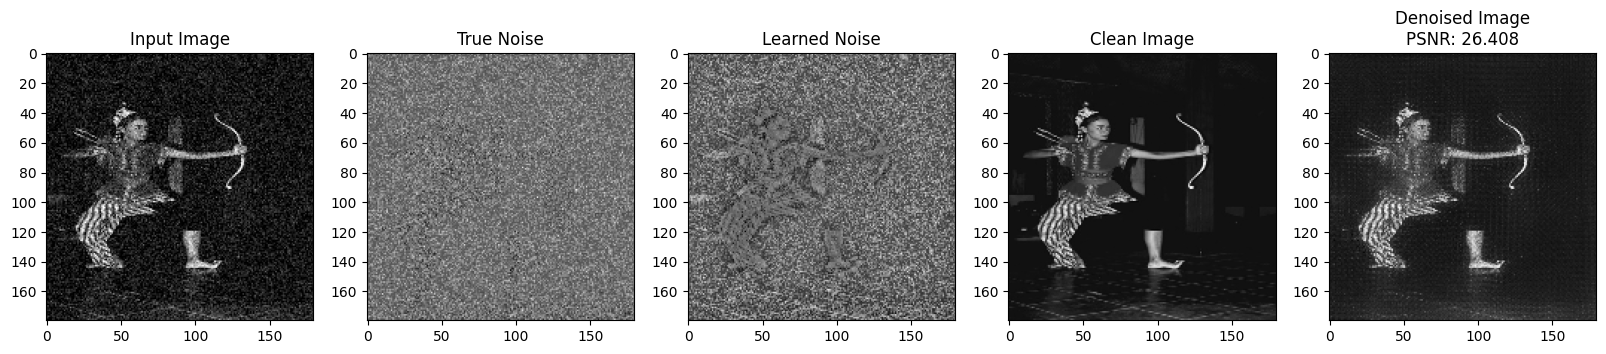

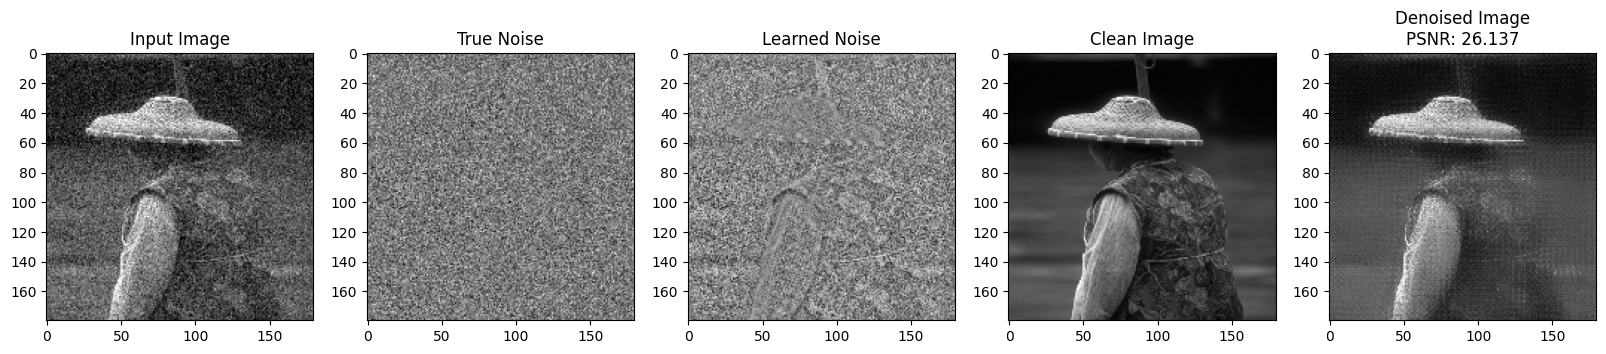

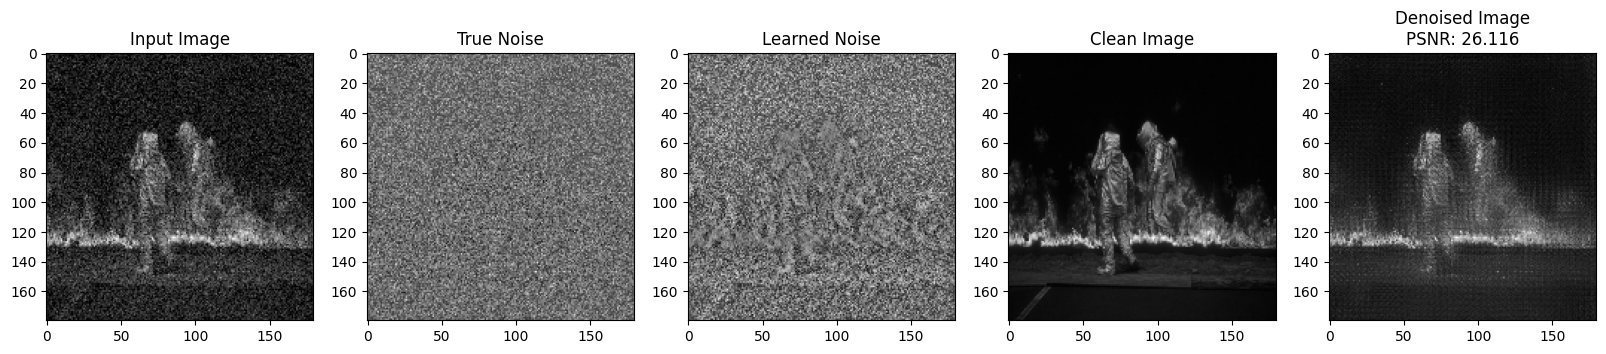

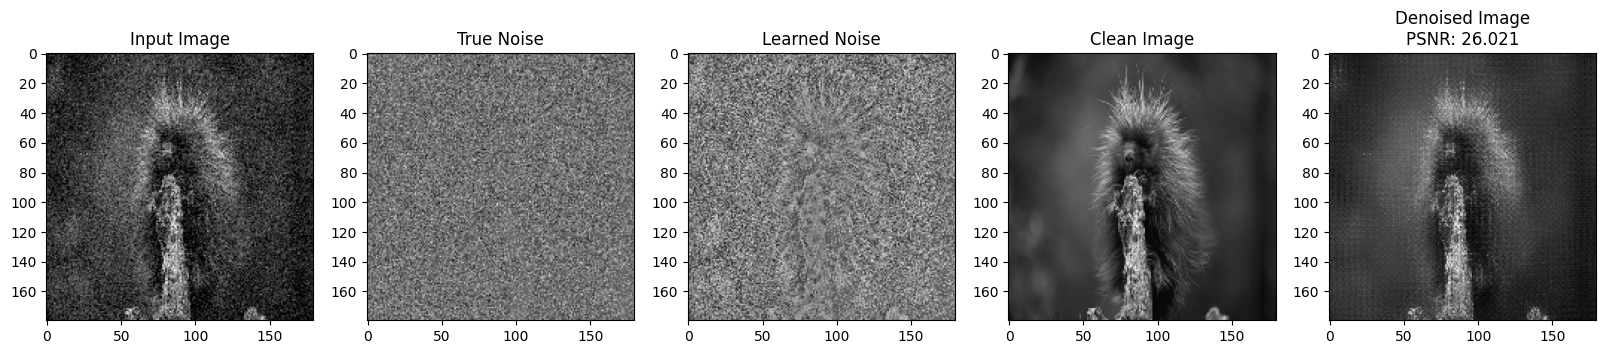

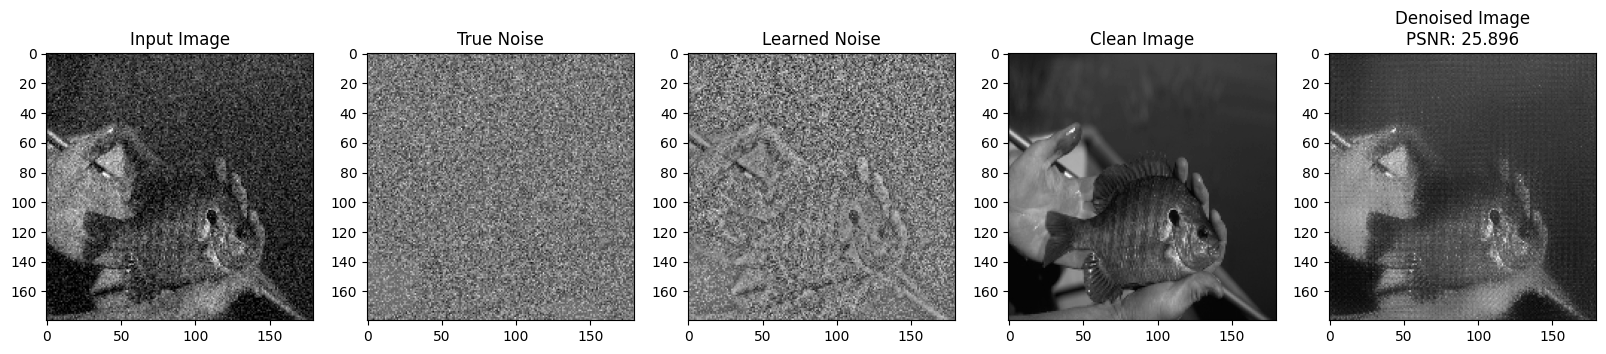

In [ ]:
model_name = 'ID_DL_DnCNN_B'
hp = args['hyper']
path = args['paths']

test_batches_gpu = getTestDataBatches(path['test_data'], 'DnCNN-S', hp['noise_levels'],isGrayscale=True)

inputs, labels, outputs = test(model_name,test_batches_gpu,hp['depth'], hp['kernel_size'], hp['dilation'],isGrayscale=True)

print(f"Total Test Loss: {getTotalLoss(labels, outputs)}")

getOutput(inputs, labels, outputs)
del inputs, labels, outputs